# Mineria de Datos
## Trabajo practico 3


## Docentes
- Spetale Flavio 
- Vasquez Facundo 

## Integrantes
- Arenas Agustín
- Petetta Nicola


### Año 2024



In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import confusion_matrix, classification_report, make_scorer
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Para ver que es cada score ----- > https://database.coffeeinstitute.org/coffee/976032/grade

# 1.Analizar los atributos del conjunto de datos

## 1.1 Lectura y vistazo rapido

En el archivo csv estan separados por ";" asi que en los parametros del metodo read_csv de pandas ajustamos esto para una lectura correcta

In [4]:
dataframe = pd.read_csv('CoffeeRatings.csv', delimiter=';')
dataframe.head()

,Scores_Aroma,Scores_Flavor,Scores_Aftertaste,Scores_Acidity,Scores_Body,Scores_Balance,Scores_Uniformity,Scores_Sweetness,Scores_Moisture,Scores_Total,Color
0,85,85,80,80,80,80,100,100,12,8692,Green
1,85,817,80,775,80,80,100,100,12,8642,Green
2,833,80,80,80,775,80,100,100,11,8608,Blue-Green
3,80,80,80,767,775,80,100,100,11,8542,Blue-Green
4,80,792,775,775,80,775,100,100,11,8492,Green


- Aroma: El aspecto aromatico del cafe cuando se le agrega agua caliente
- Flavor: Gusto "principal"
- Aftertaste: Duracion del gusto positivo una vez tragado el cafe
- Acidity: Intensidad del cafe al tomarlo
- Body: sensacion en la lengua y el paladar
- Balance: Mezcla de los parametros anteriores
- Uniformity: consistencia del sabor en distintas tazas
- Sweetness: Sabor dulce
- Moisture: humedad del grano en % (10-12 es lo optimo)

Correcion de errores

Recalibrar columnas

In [5]:
cols_scores = dataframe.drop(['Scores_Total'], axis = 1).describe().columns

dataframe = dataframe.copy()

Definir una función para corregir los valores

In [6]:
def corregir_valor(valor):
    if 10 < valor < 100:  # Valor con 2 cifras
        return valor / 10
    elif 100 <= valor <= 1000:  # Valor con 3 cifras
        return valor / 100
    return valor  # Mantener el valor si no cumple las condiciones


Aplicar la función a cada elemento del DataFrame

In [7]:
dataframe[cols_scores] = dataframe[cols_scores].applymap(corregir_valor)

In [8]:
# Recalcular el promedio
dataframe['Scores_Total'] = dataframe[cols_scores].mean(axis=1)

Se elimina la columna scores_total por un error de codificacion del archivo csv

In [9]:
#dataframe = dataframe.drop('Scores_Total', axis=1)

No tenemos nulos

In [10]:
dataframe.isnull().any()

Scores_Aroma         False
Scores_Flavor        False
Scores_Aftertaste    False
Scores_Acidity       False
Scores_Body          False
Scores_Balance       False
Scores_Uniformity    False
Scores_Sweetness     False
Scores_Moisture      False
Scores_Total         False
Color                False
dtype: bool

Ni duplicados

In [11]:
dataframe.duplicated().sum()

0

informacion extra

In [12]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835 entries, 0 to 834
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Scores_Aroma       835 non-null    float64
 1   Scores_Flavor      835 non-null    float64
 2   Scores_Aftertaste  835 non-null    float64
 3   Scores_Acidity     835 non-null    float64
 4   Scores_Body        835 non-null    float64
 5   Scores_Balance     835 non-null    float64
 6   Scores_Uniformity  835 non-null    float64
 7   Scores_Sweetness   835 non-null    float64
 8   Scores_Moisture    835 non-null    float64
 9   Scores_Total       835 non-null    float64
 10  Color              835 non-null    object 
dtypes: float64(10), object(1)
memory usage: 71.9+ KB


## 1.2 Variable a predecir

Antes de ver las variables numericas observamos los colores, vemos que los granos verdes son casi el 82% de los datos
Este desbalance puede causar algun error en la clasificacion

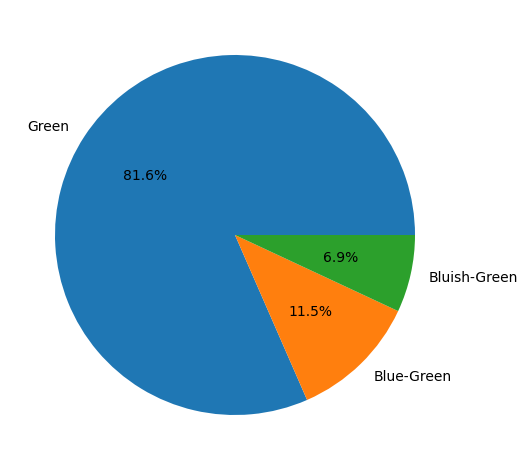

In [13]:
fig, ax = plt.subplots()
ax.pie(dataframe['Color'].value_counts(), labels=dataframe['Color'].unique(), autopct='%1.1f%%')
plt.tight_layout()
plt.show()

## 1.3 Variables numericas

In [14]:
dataframe.describe()

,Scores_Aroma,Scores_Flavor,Scores_Aftertaste,Scores_Acidity,Scores_Body,Scores_Balance,Scores_Uniformity,Scores_Sweetness,Scores_Moisture,Scores_Total
count,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000
mean,7.574874,7.514922,7.388096,7.542180,7.502347,7.502108,2.068479,1.681533,1.162635,5.548575
std,0.404096,0.420354,0.424397,0.404967,0.395293,0.427643,2.708088,2.162103,1.250848,0.510794
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.133333
25%,7.420000,7.330000,7.250000,7.420000,7.330000,7.330000,1.000000,1.000000,1.000000,5.285000
50%,7.580000,7.500000,7.420000,7.580000,7.500000,7.500000,1.000000,1.000000,1.100000,5.391111
75%,7.750000,7.750000,7.580000,7.750000,7.670000,7.750000,1.000000,1.000000,1.200000,5.586667
max,8.750000,8.830000,8.670000,8.750000,8.500000,8.580000,9.330000,9.330000,9.000000,7.570000


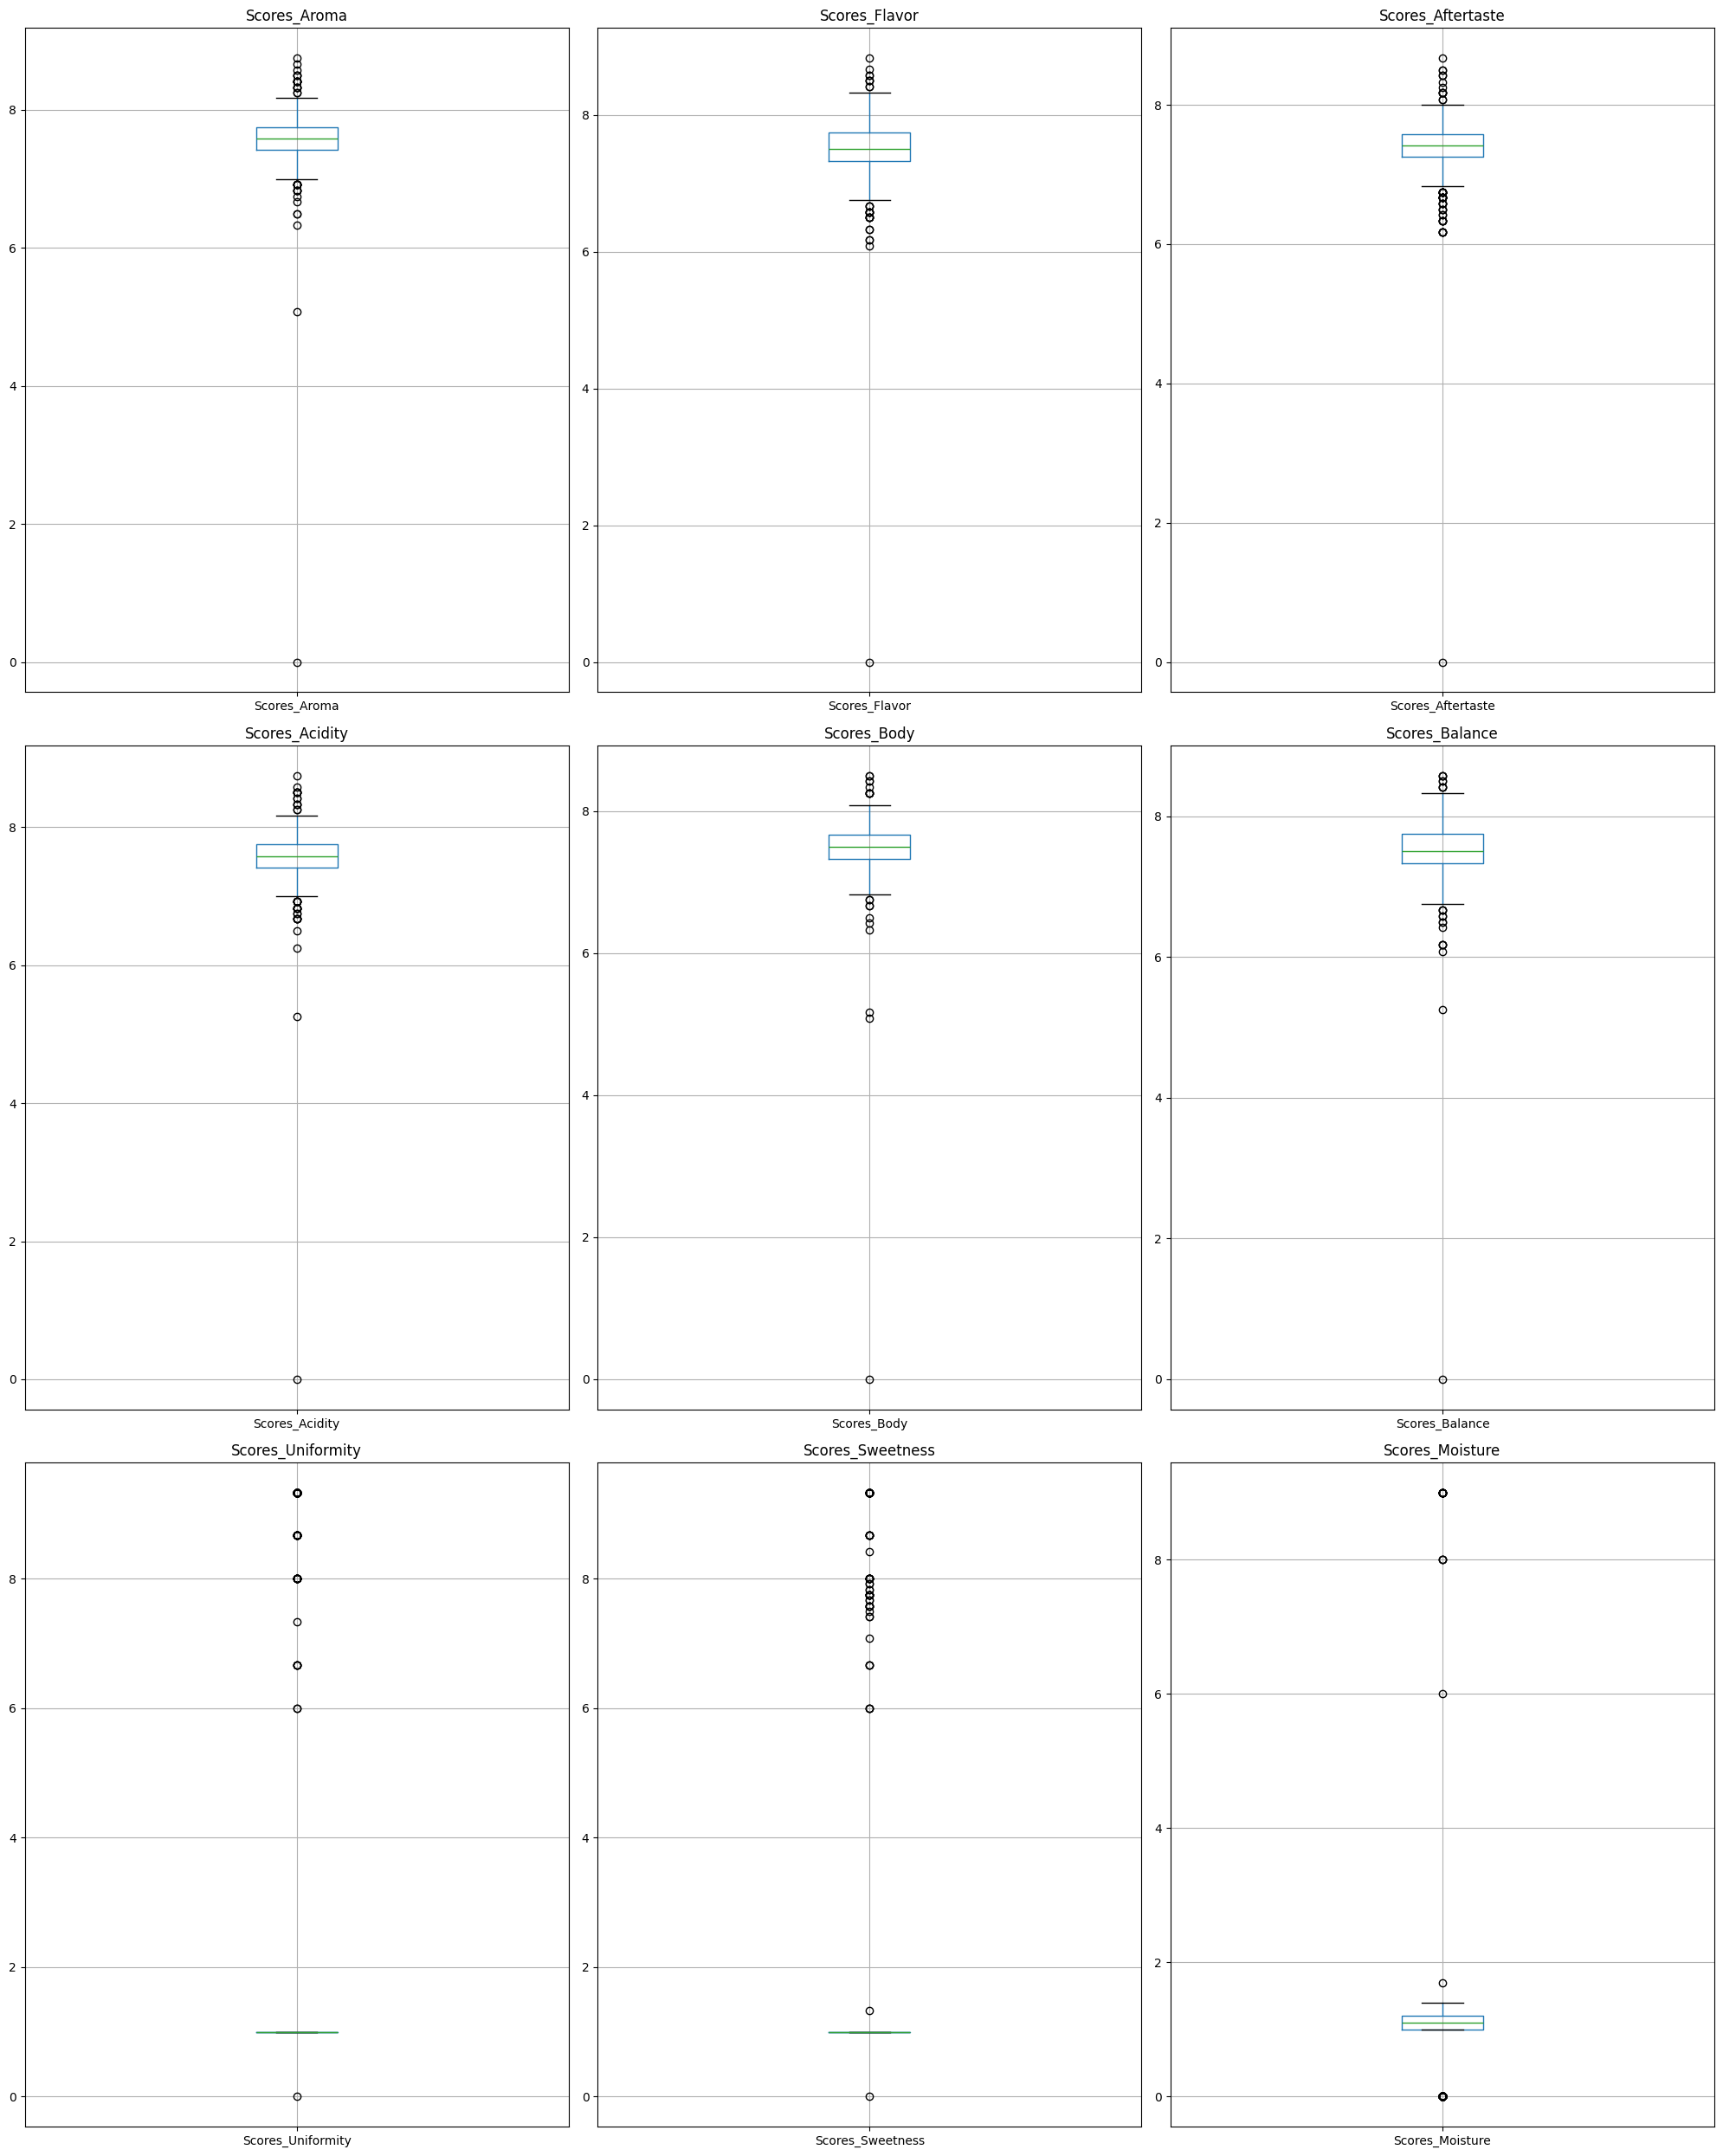

In [15]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 25))
axes = axes.flatten() 
for i, col in enumerate(dataframe.columns[:9]):
    dataframe.boxplot(column=col, ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

In [16]:
numeric_columns = [column for column in dataframe.columns if column != 'Color']

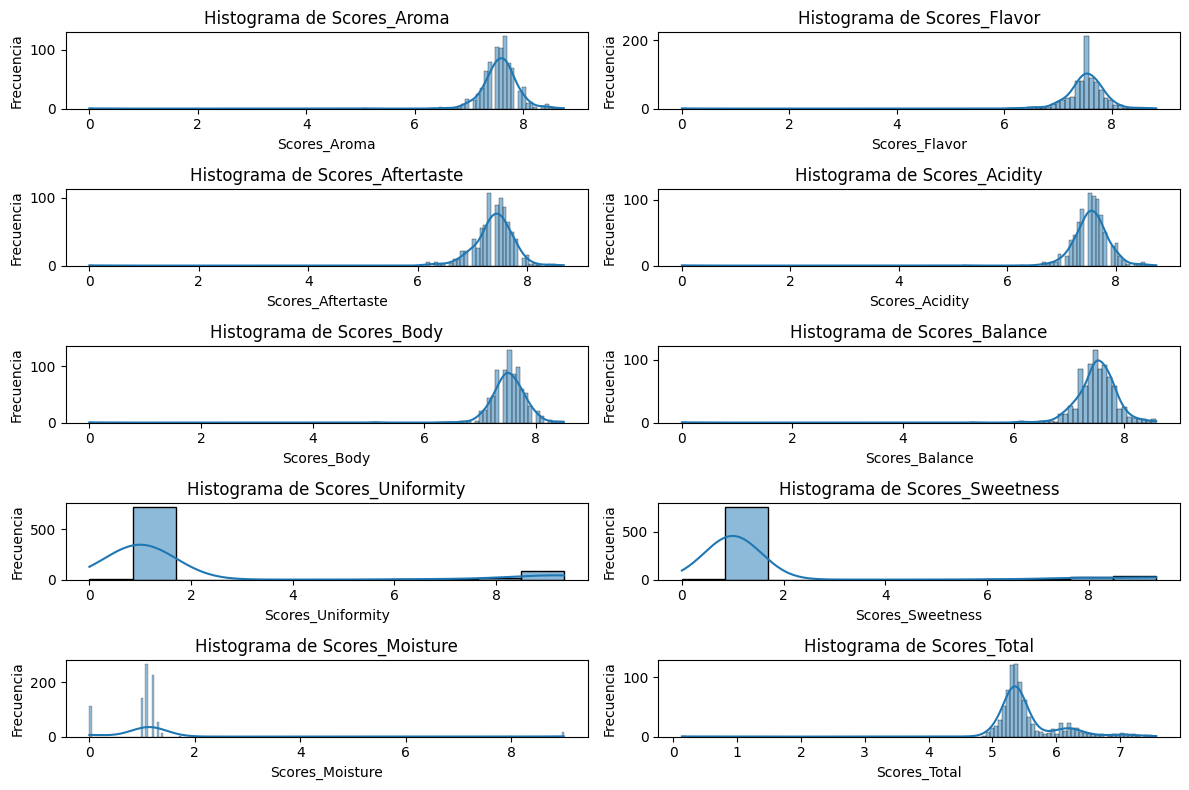

In [17]:
plt.figure(figsize=(12, 8))

for i, columna in enumerate(numeric_columns):
    plt.subplot((len(numeric_columns) + 1)//2, 2, i+1)
    sns.histplot(dataframe[columna], kde=True) 
    plt.title(f'Histograma de {columna}')
    plt.xlabel(columna)
    plt.ylabel('Frecuencia')


plt.tight_layout()
plt.show()

## 1.3 Observacion sobre la distribucion binomial

In [18]:
numeric_columns
for i in numeric_columns:
    print(dataframe.loc[(dataframe[i] >= 2.0) & (dataframe[i] <= 5.0)])

Empty DataFrame
Columns: [Scores_Aroma, Scores_Flavor, Scores_Aftertaste, Scores_Acidity, Scores_Body, Scores_Balance, Scores_Uniformity, Scores_Sweetness, Scores_Moisture, Scores_Total, Color]
Index: []
Empty DataFrame
Columns: [Scores_Aroma, Scores_Flavor, Scores_Aftertaste, Scores_Acidity, Scores_Body, Scores_Balance, Scores_Uniformity, Scores_Sweetness, Scores_Moisture, Scores_Total, Color]
Index: []
Empty DataFrame
Columns: [Scores_Aroma, Scores_Flavor, Scores_Aftertaste, Scores_Acidity, Scores_Body, Scores_Balance, Scores_Uniformity, Scores_Sweetness, Scores_Moisture, Scores_Total, Color]
Index: []
Empty DataFrame
Columns: [Scores_Aroma, Scores_Flavor, Scores_Aftertaste, Scores_Acidity, Scores_Body, Scores_Balance, Scores_Uniformity, Scores_Sweetness, Scores_Moisture, Scores_Total, Color]
Index: []
Empty DataFrame
Columns: [Scores_Aroma, Scores_Flavor, Scores_Aftertaste, Scores_Acidity, Scores_Body, Scores_Balance, Scores_Uniformity, Scores_Sweetness, Scores_Moisture, Scores_Tota

- Vemos que de 200 a 500 en las variables numericas no hay valores, esto refleja sobre la forma en la que se evaluan los granos, quizas mas que un score numerico podria ser bueno/malo

# 1.4 Separar las columnas en X e y

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X = dataframe.drop('Color', axis=1)
y = dataframe['Color']

# 1.5 split del conjunto de datos en train test 80/20

In [21]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1.6 Normalizar el dataset para modelado

In [22]:
scaler = StandardScaler()
X_train_escalado = scaler.fit_transform(X_train)
X_test_escalado = scaler.transform(X_test)

# 1.7 GRID SEARCH PARA LOS PARAMETROS SOLICITADOS DE LAS SVM

## 1.8 Costo con Kernel lineal

In [23]:
svm_params = SVC(random_state=42)

# Definir los hiperparámetros
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear'],    
    'class_weight':['balanced'],
}


grid_search = GridSearchCV(estimator=svm_params, param_grid=param_grid, scoring = ['accuracy', 'precision_macro', 'recall_macro'], refit='accuracy')


grid_search.fit(X_train_escalado, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print('Mejores hiperparámetros:', best_params)

Mejores hiperparámetros: {'C': 0.1, 'class_weight': 'balanced', 'kernel': 'linear'}


## 1.9 Costo y gamma con kernel gaussiano

In [24]:
# Definición de un modelo clasificador de Random Forest
svm_params = SVC(random_state=42)

# Definir los hiperparámetros a ajustar y sus posibles valores
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf'],
    'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
    'class_weight':['balanced'],

}

# Configurar la búsqueda grid con validación cruzada (cross-validation)
grid_search = GridSearchCV(estimator=svm_params, param_grid=param_grid, scoring = ['accuracy', 'precision_macro', 'recall_macro'], refit='accuracy')

# Realizar la búsqueda grid en el conjunto de entrenamiento
grid_search.fit(X_train_escalado, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print('Mejores hiperparámetros:', best_params)

Mejores hiperparámetros: {'C': 1, 'class_weight': 'balanced', 'gamma': 100, 'kernel': 'rbf'}


# 2.Realizar la predicción del atributo Color utilizando máquinas de vectores con kernel lineal analizando el parámetro costo

## 2.1 SVM Con Kernel lineal y analizando el parametro costo SIN CROSSVALIDATION


In [25]:
svm_linear_nocross = SVC(kernel='linear', C=0.1, class_weight='balanced', random_state=42)

In [26]:
svm_linear_nocross.fit(X_train_escalado, y_train)

SVC(C=0.1, class_weight='balanced', kernel='linear', random_state=42)

In [27]:
# Predicciones
y_pred_linear = svm_linear_nocross.predict(X_test_escalado)

# Evaluación
accuracy = accuracy_score(y_test, y_pred_linear)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 40.72%


In [28]:
dataframe['Color'].value_counts()

Color
Green           681
Bluish-Green     96
Blue-Green       58
Name: count, dtype: int64

              precision    recall  f1-score   support

  Blue-Green       0.11      0.50      0.18        12
Bluish-Green       0.14      0.35      0.20        20
       Green       0.89      0.41      0.56       135

    accuracy                           0.41       167
   macro avg       0.38      0.42      0.31       167
weighted avg       0.74      0.41      0.49       167



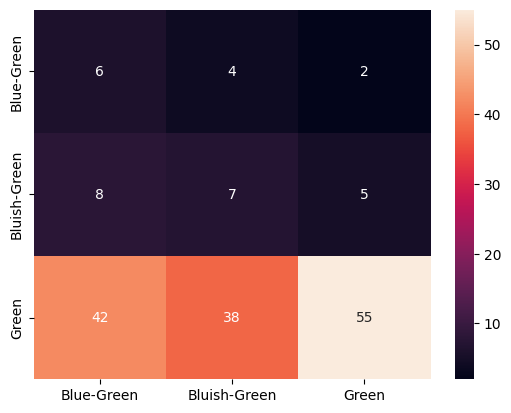

In [29]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


cm = (confusion_matrix(y_test, y_pred_linear))
a = ["Blue-Green", "Bluish-Green", "Green"]

sns.heatmap(cm, xticklabels = a, yticklabels = a,annot=True, fmt='g')

print(classification_report(y_test, y_pred_linear))

## 2.2 Kernel lineal con cross validation

In [30]:
svm = SVC(kernel='linear', C=0.1, class_weight='balanced')

In [31]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

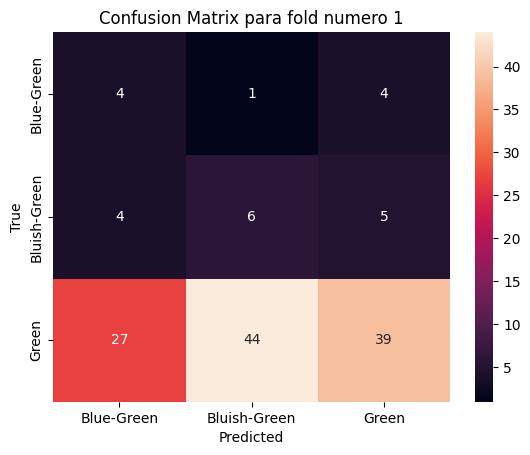

Classification Report para fold numero 1:
               precision    recall  f1-score   support

  Blue-Green       0.11      0.44      0.18         9
Bluish-Green       0.12      0.40      0.18        15
       Green       0.81      0.35      0.49       110

    accuracy                           0.37       134
   macro avg       0.35      0.40      0.29       134
weighted avg       0.69      0.37      0.44       134



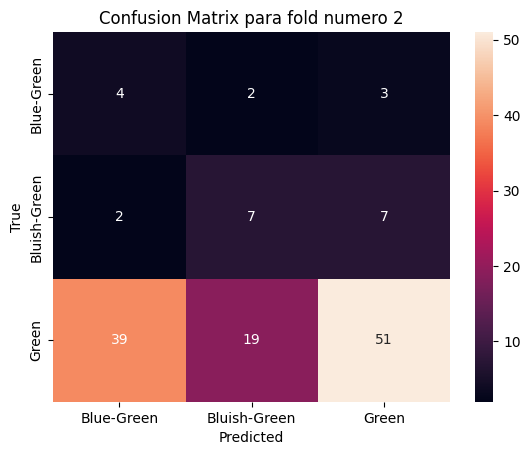

Classification Report para fold numero 2:
               precision    recall  f1-score   support

  Blue-Green       0.09      0.44      0.15         9
Bluish-Green       0.25      0.44      0.32        16
       Green       0.84      0.47      0.60       109

    accuracy                           0.46       134
   macro avg       0.39      0.45      0.36       134
weighted avg       0.72      0.46      0.54       134



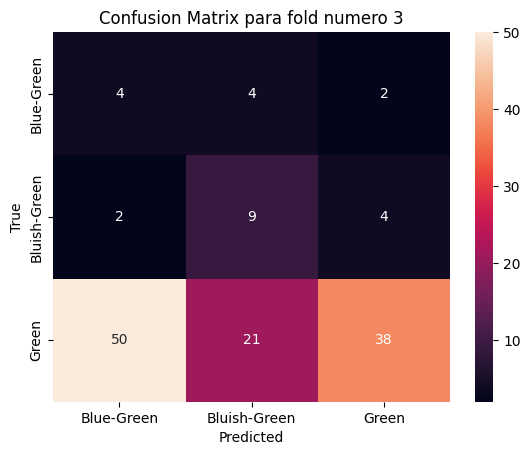

Classification Report para fold numero 3:
               precision    recall  f1-score   support

  Blue-Green       0.07      0.40      0.12        10
Bluish-Green       0.26      0.60      0.37        15
       Green       0.86      0.35      0.50       109

    accuracy                           0.38       134
   macro avg       0.40      0.45      0.33       134
weighted avg       0.74      0.38      0.45       134



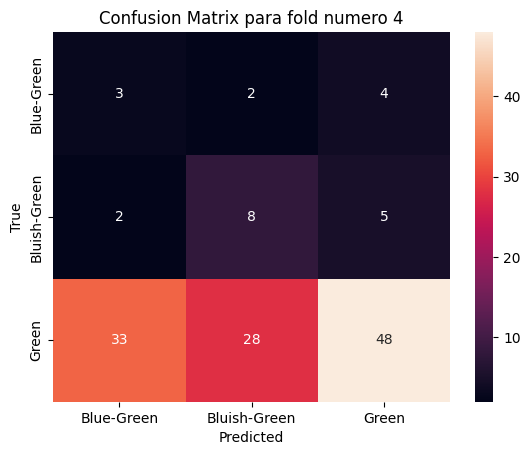

Classification Report para fold numero 4:
               precision    recall  f1-score   support

  Blue-Green       0.08      0.33      0.13         9
Bluish-Green       0.21      0.53      0.30        15
       Green       0.84      0.44      0.58       109

    accuracy                           0.44       133
   macro avg       0.38      0.44      0.34       133
weighted avg       0.72      0.44      0.52       133



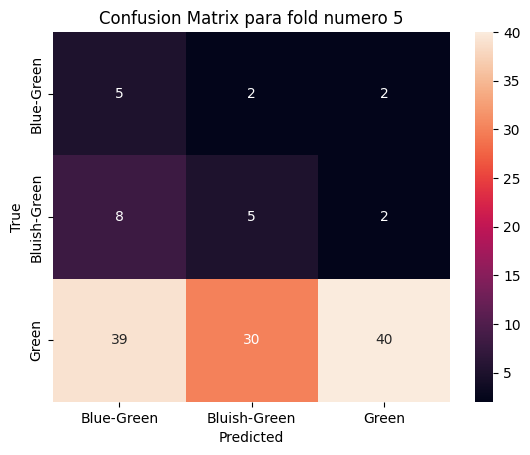

Classification Report para fold numero 5:
               precision    recall  f1-score   support

  Blue-Green       0.10      0.56      0.16         9
Bluish-Green       0.14      0.33      0.19        15
       Green       0.91      0.37      0.52       109

    accuracy                           0.38       133
   macro avg       0.38      0.42      0.29       133
weighted avg       0.77      0.38      0.46       133



In [32]:
fold = 1
for i, (train_index, val_index) in enumerate(kf.split(X_train_escalado, y_train)):
    
    #evitar el error out of index
    index_labels = y_train.index
    trainsc_df = pd.DataFrame(X_train_escalado, index=index_labels)


    X_train_fold, X_val_fold = trainsc_df.iloc[train_index], trainsc_df.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Train the model on the training fold
    svm.fit(X_train_fold, y_train_fold)

    # Predict on the validation fold
    y_pred_fold = svm.predict(X_val_fold)

    # Compute confusion matrix and classification report
    cm = confusion_matrix(y_val_fold, y_pred_fold)
    # Matriz de confusion x cada fold
    a = ["Blue-Green", "Bluish-Green", "Green"]
    sns.heatmap(cm, xticklabels=a, yticklabels=a, annot=True, fmt='g')
    plt.title(f"Confusion Matrix para fold numero {fold}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Print classification report
    print(f"Classification Report para fold numero {fold}:\n", classification_report(y_val_fold, y_pred_fold))

    fold += 1

- El modelo generaliza igual sobre el conjunto de test
- ambos modelos (con y sin Cross validation) tienen recall de 1 en la clase green
- Todos los datos de green se predicen correctamente
- Se predicen como green algunos otros valores, pero como la cantidad de green es tan alta la accuracy es de 85% lo cual es alta


# 3. Realizar la predicción del atributo Color utilizando máquinas de vectores con kernelgaussiano analizando los parámetros costo y gama


## 3.1 SVM con kernel gaussiano sin cross validation

In [33]:
svm_gauss_nocross = SVC(kernel='rbf', C=0.1,class_weight='balanced', random_state=42, gamma=0.001)

In [34]:
svm_gauss_nocross.fit(X_train_escalado, y_train)

SVC(C=0.1, class_weight='balanced', gamma=0.001, random_state=42)

In [35]:
# Predicciones
y_pred_gauss = svm_linear_nocross.predict(X_test_escalado)

# Evaluación
accuracy = accuracy_score(y_test, y_pred_gauss)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 40.72%


In [36]:
dataframe['Color'].value_counts()

Color
Green           681
Bluish-Green     96
Blue-Green       58
Name: count, dtype: int64

              precision    recall  f1-score   support

  Blue-Green       0.11      0.50      0.18        12
Bluish-Green       0.14      0.35      0.20        20
       Green       0.89      0.41      0.56       135

    accuracy                           0.41       167
   macro avg       0.38      0.42      0.31       167
weighted avg       0.74      0.41      0.49       167



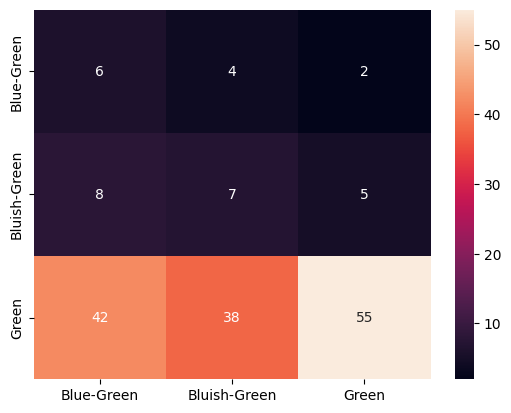

In [37]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


cm = (confusion_matrix(y_test, y_pred_gauss))
a = ["Blue-Green", "Bluish-Green", "Green"]

sns.heatmap(cm, xticklabels = a, yticklabels = a,annot=True, fmt='g')

print(classification_report(y_test, y_pred_gauss))

## 3.2 SVM con Kernel gaussiano y cross validation

In [38]:
svm_gaussiano = SVC(kernel='rbf', C=0.1, random_state=42, gamma=0.001, class_weight='balanced')

In [39]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

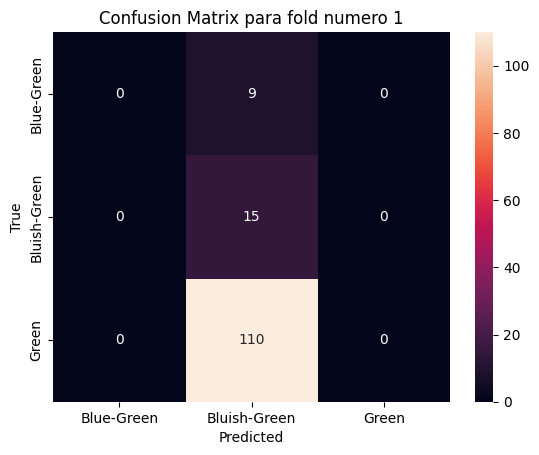

Classification Report para fold numero 1:
               precision    recall  f1-score   support

  Blue-Green       0.00      0.00      0.00         9
Bluish-Green       0.11      1.00      0.20        15
       Green       0.00      0.00      0.00       110

    accuracy                           0.11       134
   macro avg       0.04      0.33      0.07       134
weighted avg       0.01      0.11      0.02       134



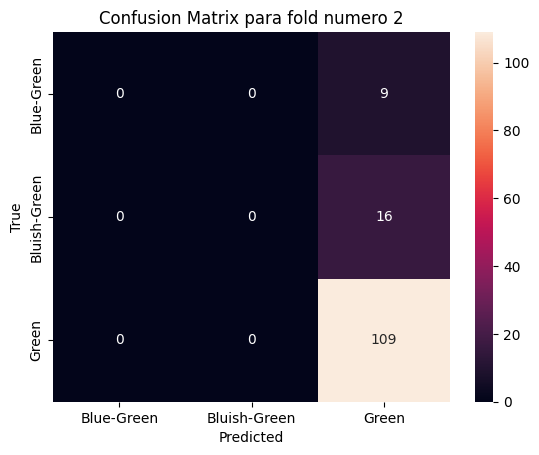

Classification Report para fold numero 2:
               precision    recall  f1-score   support

  Blue-Green       0.00      0.00      0.00         9
Bluish-Green       0.00      0.00      0.00        16
       Green       0.81      1.00      0.90       109

    accuracy                           0.81       134
   macro avg       0.27      0.33      0.30       134
weighted avg       0.66      0.81      0.73       134



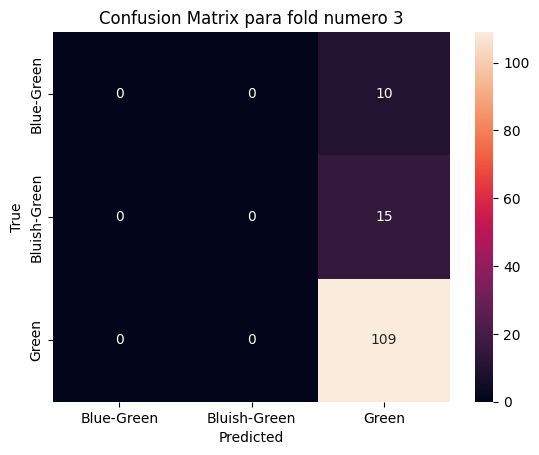

Classification Report para fold numero 3:
               precision    recall  f1-score   support

  Blue-Green       0.00      0.00      0.00        10
Bluish-Green       0.00      0.00      0.00        15
       Green       0.81      1.00      0.90       109

    accuracy                           0.81       134
   macro avg       0.27      0.33      0.30       134
weighted avg       0.66      0.81      0.73       134



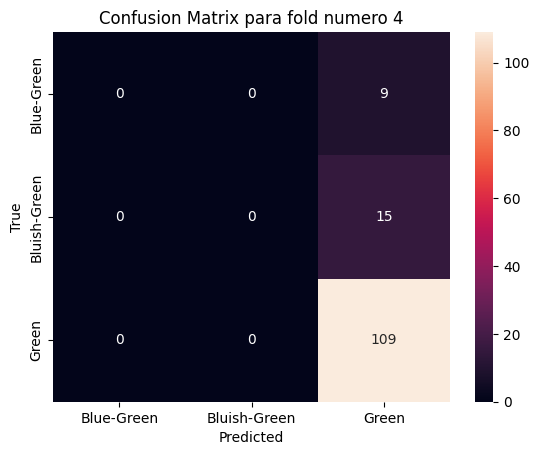

Classification Report para fold numero 4:
               precision    recall  f1-score   support

  Blue-Green       0.00      0.00      0.00         9
Bluish-Green       0.00      0.00      0.00        15
       Green       0.82      1.00      0.90       109

    accuracy                           0.82       133
   macro avg       0.27      0.33      0.30       133
weighted avg       0.67      0.82      0.74       133



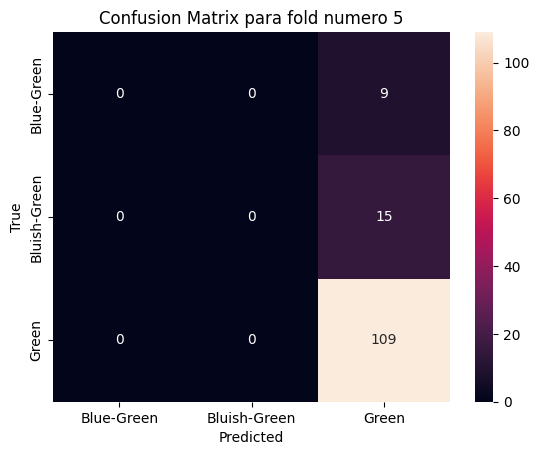

Classification Report para fold numero 5:
               precision    recall  f1-score   support

  Blue-Green       0.00      0.00      0.00         9
Bluish-Green       0.00      0.00      0.00        15
       Green       0.82      1.00      0.90       109

    accuracy                           0.82       133
   macro avg       0.27      0.33      0.30       133
weighted avg       0.67      0.82      0.74       133



In [40]:
fold = 1
for i, (train_index, val_index) in enumerate(kf.split(X_train_escalado, y_train)):
    
    #evitar el error out of index
    index_labels = y_train.index
    trainsc_df = pd.DataFrame(X_train_escalado, index=index_labels)


    X_train_fold, X_val_fold = trainsc_df.iloc[train_index], trainsc_df.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Train the model on the training fold
    svm_gaussiano.fit(X_train_fold, y_train_fold)

    # Predict on the validation fold
    y_pred_fold = svm_gaussiano.predict(X_val_fold)

    # Compute confusion matrix and classification report
    cm = confusion_matrix(y_val_fold, y_pred_fold)
    # Matriz de confusion x cada fold
    a = ["Blue-Green", "Bluish-Green", "Green"]
    sns.heatmap(cm, xticklabels=a, yticklabels=a, annot=True, fmt='g')
    plt.title(f"Confusion Matrix para fold numero {fold}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Print classification report
    print(f"Classification Report para fold numero {fold}:\n", classification_report(y_val_fold, y_pred_fold))



    fold += 1

# 4. Realizar la predicción del atributo Color utilizando Random Forest analizando los parámetros cantidad de estimadores y la máxima profundidad de los árboles

## 4.1 random forest sin cross validation

In [41]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

In [42]:
forest_nocross = RandomForestClassifier(random_state=42, class_weight='balanced')

In [43]:
forest_nocross.fit(X_train_escalado, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [44]:
# Predicciones
y_pred_forest = forest_nocross.predict(X_test_escalado)

# Evaluación
accuracy = accuracy_score(y_test, y_pred_forest)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 80.24%


              precision    recall  f1-score   support

  Blue-Green       0.11      0.50      0.18        12
Bluish-Green       0.14      0.35      0.20        20
       Green       0.89      0.41      0.56       135

    accuracy                           0.41       167
   macro avg       0.38      0.42      0.31       167
weighted avg       0.74      0.41      0.49       167



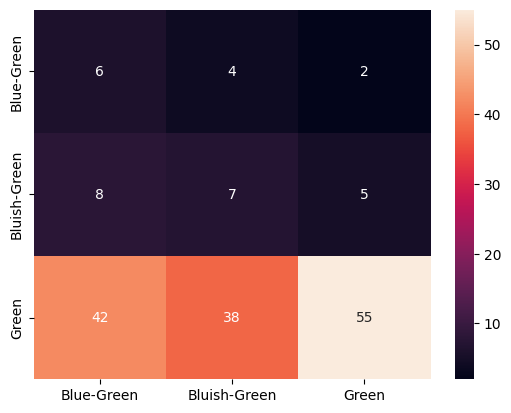

In [45]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


cm = (confusion_matrix(y_test, y_pred_linear))
a = ["Blue-Green", "Bluish-Green", "Green"]

sns.heatmap(cm, xticklabels = a, yticklabels = a,annot=True, fmt='g')

print(classification_report(y_test, y_pred_linear))

## 4.2 Random forest con cross validation e hiperparametros ajustados mediante grid search

In [46]:
rf_classifier = RandomForestClassifier(random_state=42)

# Definir los hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [30, 50],
    'class_weight':['balanced'],

}


grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring = ['accuracy', 'precision_macro', 'recall_macro'], refit='accuracy')


grid_search.fit(X_train_escalado, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
opt_rfd = grid_search.best_estimator_
print('Mejores hiperparámetros:', best_params)

Mejores hiperparámetros: {'class_weight': 'balanced', 'max_depth': 30, 'n_estimators': 150}


Mejores hiperparámetros: {'class_weight': 'balanced', 'max_depth': 30, 'max_features': 'sqrt', 'max_leaf_nodes': 300, 'max_samples': 50, 'min_samples_leaf': 10, 'n_estimators': 50, 'random_state': 42}

In [47]:
rand_forest = RandomForestClassifier(class_weight='balanced',max_depth= 30, max_features='sqrt', max_leaf_nodes= 300, max_samples= 50, min_samples_leaf= 10, n_estimators= 50, random_state=42)

In [48]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

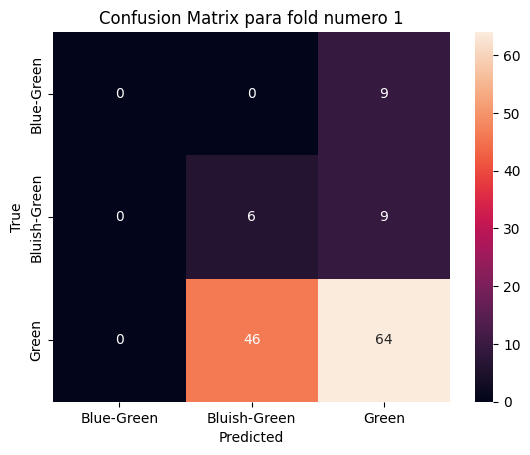

Classification Report para fold numero 1:
               precision    recall  f1-score   support

  Blue-Green       0.00      0.00      0.00         9
Bluish-Green       0.12      0.40      0.18        15
       Green       0.78      0.58      0.67       110

    accuracy                           0.52       134
   macro avg       0.30      0.33      0.28       134
weighted avg       0.65      0.52      0.57       134



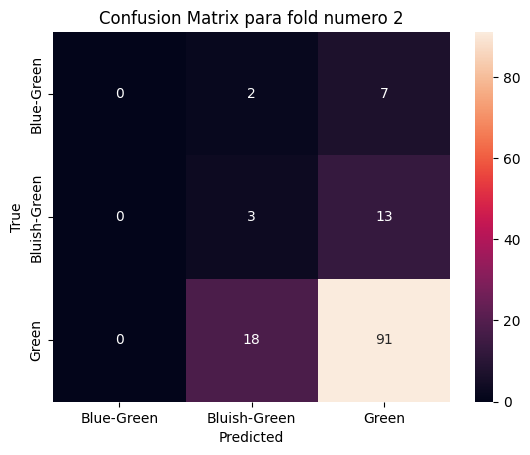

Classification Report para fold numero 2:
               precision    recall  f1-score   support

  Blue-Green       0.00      0.00      0.00         9
Bluish-Green       0.13      0.19      0.15        16
       Green       0.82      0.83      0.83       109

    accuracy                           0.70       134
   macro avg       0.32      0.34      0.33       134
weighted avg       0.68      0.70      0.69       134



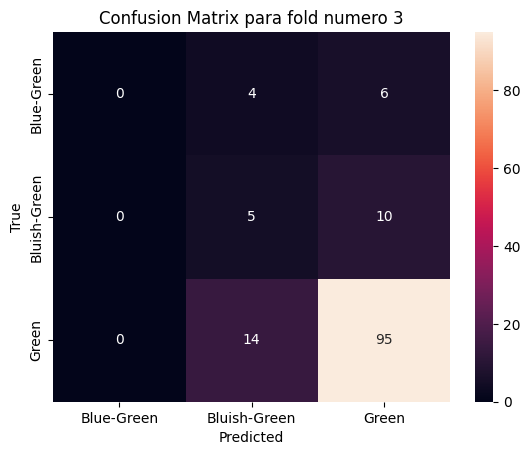

Classification Report para fold numero 3:
               precision    recall  f1-score   support

  Blue-Green       0.00      0.00      0.00        10
Bluish-Green       0.22      0.33      0.26        15
       Green       0.86      0.87      0.86       109

    accuracy                           0.75       134
   macro avg       0.36      0.40      0.38       134
weighted avg       0.72      0.75      0.73       134



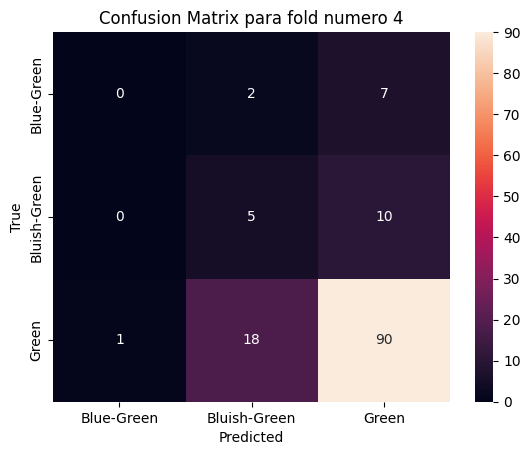

Classification Report para fold numero 4:
               precision    recall  f1-score   support

  Blue-Green       0.00      0.00      0.00         9
Bluish-Green       0.20      0.33      0.25        15
       Green       0.84      0.83      0.83       109

    accuracy                           0.71       133
   macro avg       0.35      0.39      0.36       133
weighted avg       0.71      0.71      0.71       133



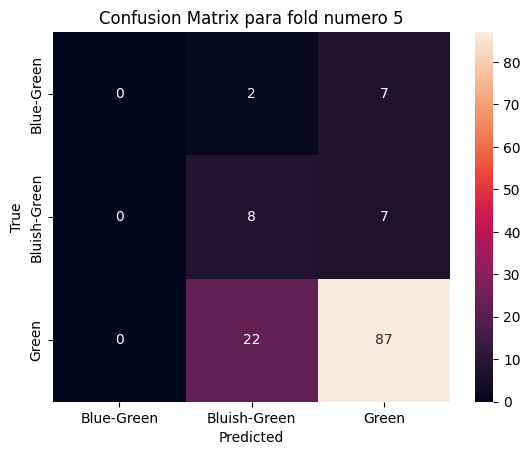

Classification Report para fold numero 5:
               precision    recall  f1-score   support

  Blue-Green       0.00      0.00      0.00         9
Bluish-Green       0.25      0.53      0.34        15
       Green       0.86      0.80      0.83       109

    accuracy                           0.71       133
   macro avg       0.37      0.44      0.39       133
weighted avg       0.73      0.71      0.72       133



In [49]:
fold = 1
for i, (train_index, val_index) in enumerate(kf.split(X_train_escalado, y_train)):
    
    #evitar el error out of index
    index_labels = y_train.index
    trainsc_df = pd.DataFrame(X_train_escalado, index=index_labels)


    X_train_fold, X_val_fold = trainsc_df.iloc[train_index], trainsc_df.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Train the model on the training fold
    rand_forest.fit(X_train_fold, y_train_fold)

    # Predict on the validation fold
    y_pred_fold = rand_forest.predict(X_val_fold)

    # Compute confusion matrix and classification report
    cm = confusion_matrix(y_val_fold, y_pred_fold)
    # Matriz de confusion x cada fold
    a = ["Blue-Green", "Bluish-Green", "Green"]
    sns.heatmap(cm, xticklabels=a, yticklabels=a, annot=True, fmt='g')
    plt.title(f"Confusion Matrix para fold numero {fold}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Print classification report
    print(f"Classification Report para fold numero {fold}:\n", classification_report(y_val_fold, y_pred_fold))



    fold += 1

barplot mejores features

In [50]:
cols_pred = list(X_train.columns.values)

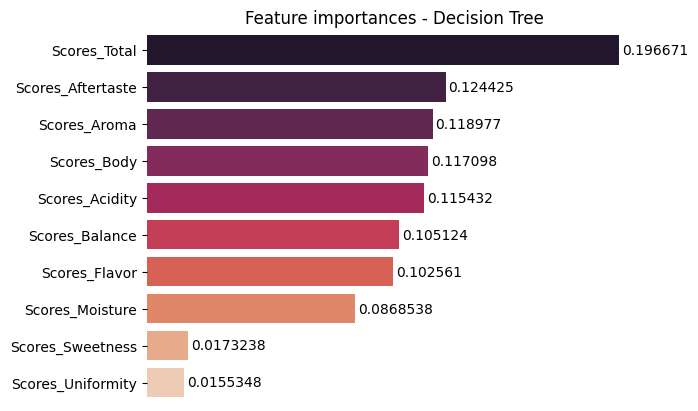

In [51]:
#columnas e importancia
features_df = pd.DataFrame({'features': cols_pred, 'importances': opt_rfd.feature_importances_ })

# ordenar de mayor a menor
features_df_sorted = features_df.sort_values(by='importances', ascending=False)

# Barplot
g = sns.barplot(data=features_df_sorted, x='importances', y ='features', palette="rocket")
sns.despine(bottom = True, left = True)
g.set_title('Feature importances - Decision Tree')
g.set(xlabel=None)
g.set(ylabel=None)
g.set(xticks=[])
for value in g.containers:
    g.bar_label(value, padding=2)

#

# Repetir 2 3 y 4 con un split 70/30


#

## 1.5BIS Separar en train test 70/30

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 1.6BIS Normalizar el dataset para modelado

In [53]:
scaler = StandardScaler()
X_train_escalado = scaler.fit_transform(X_train)
X_test_escalado = scaler.transform(X_test)

# 1.7BIS GRID SEARCH PARA LOS PARAMETROS SOLICITADOS DE LAS SVM

## 1.6BIS Costo con Kernel lineal

In [54]:
svm_params = SVC(random_state=42)

# Definir los hiperparámetros
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear'],    
    'class_weight':['balanced'],
}


grid_search = GridSearchCV(estimator=svm_params, param_grid=param_grid, scoring = ['accuracy', 'precision_macro', 'recall_macro'], refit='accuracy')


grid_search.fit(X_train_escalado, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print('Mejores hiperparámetros:', best_params)

Mejores hiperparámetros: {'C': 0.1, 'class_weight': 'balanced', 'kernel': 'linear'}


## 1.7BIS Costo y gamma con kernel gaussiano

In [55]:
# Definición de un modelo clasificador de Random Forest
svm_params = SVC(random_state=42)

# Definir los hiperparámetros a ajustar y sus posibles valores
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf'],
    'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
    'class_weight':['balanced'],

}

# Configurar la búsqueda grid con validación cruzada (cross-validation)
grid_search = GridSearchCV(estimator=svm_params, param_grid=param_grid, scoring = ['accuracy', 'precision_macro', 'recall_macro'], refit='accuracy')

# Realizar la búsqueda grid en el conjunto de entrenamiento
grid_search.fit(X_train_escalado, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print('Mejores hiperparámetros:', best_params)

Mejores hiperparámetros: {'C': 1, 'class_weight': 'balanced', 'gamma': 100, 'kernel': 'rbf'}


# 2.BIS Realizar la predicción del atributo Color utilizando máquinas de vectores con kernel lineal analizando el parámetro costo

## 2.1BIS SVM Con Kernel lineal y analizando el parametro costo SIN CROSSVALIDATION


In [56]:
svm_linear_nocross = SVC(kernel='linear', C=0.1, random_state=42, class_weight='balanced')

In [57]:
svm_linear_nocross.fit(X_train_escalado, y_train)

SVC(C=0.1, class_weight='balanced', kernel='linear', random_state=42)

In [58]:
# Predicciones
y_pred_linear = svm_linear_nocross.predict(X_test_escalado)

# Evaluación
accuracy = accuracy_score(y_test, y_pred_linear)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 43.43%


In [59]:
dataframe['Color'].value_counts()

Color
Green           681
Bluish-Green     96
Blue-Green       58
Name: count, dtype: int64

              precision    recall  f1-score   support

  Blue-Green       0.09      0.44      0.15        16
Bluish-Green       0.15      0.34      0.21        29
       Green       0.87      0.45      0.59       206

    accuracy                           0.43       251
   macro avg       0.37      0.41      0.32       251
weighted avg       0.74      0.43      0.52       251



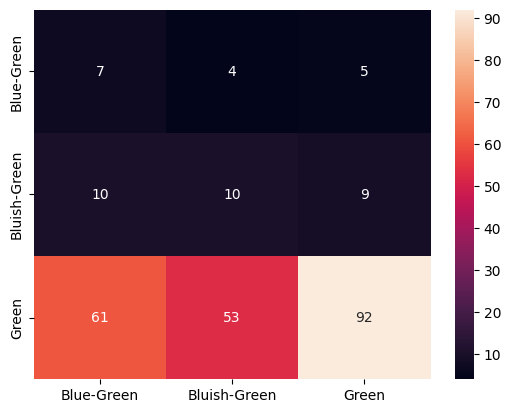

In [60]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


cm = (confusion_matrix(y_test, y_pred_linear))
a = ["Blue-Green", "Bluish-Green", "Green"]

sns.heatmap(cm, xticklabels = a, yticklabels = a,annot=True, fmt='g')

print(classification_report(y_test, y_pred_linear))

## 2.2BIS Kernel lineal con cross validation

In [61]:
svm = SVC(kernel='linear', C=0.1, class_weight='balanced')

In [62]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

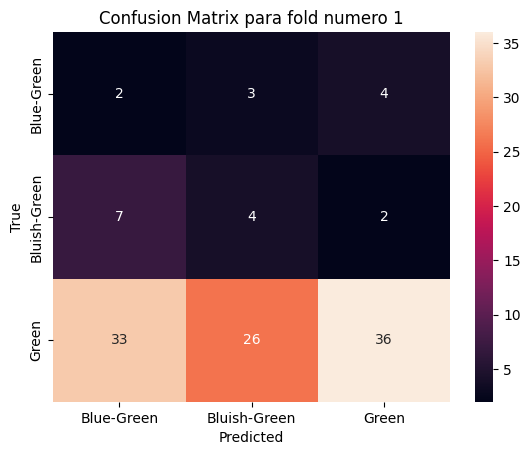

Classification Report para fold numero 1:
               precision    recall  f1-score   support

  Blue-Green       0.05      0.22      0.08         9
Bluish-Green       0.12      0.31      0.17        13
       Green       0.86      0.38      0.53        95

    accuracy                           0.36       117
   macro avg       0.34      0.30      0.26       117
weighted avg       0.71      0.36      0.45       117



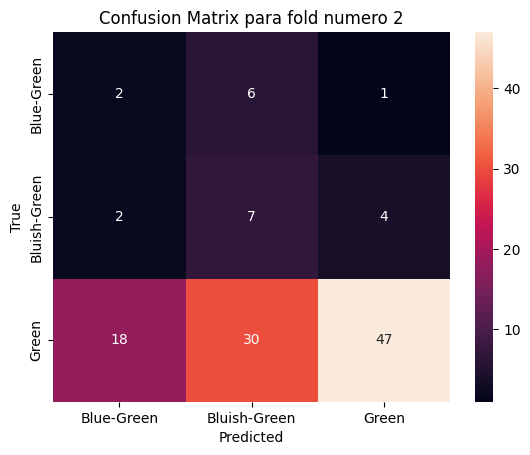

Classification Report para fold numero 2:
               precision    recall  f1-score   support

  Blue-Green       0.09      0.22      0.13         9
Bluish-Green       0.16      0.54      0.25        13
       Green       0.90      0.49      0.64        95

    accuracy                           0.48       117
   macro avg       0.39      0.42      0.34       117
weighted avg       0.76      0.48      0.56       117



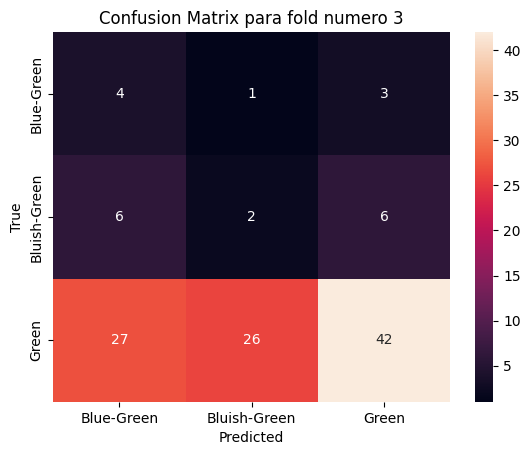

Classification Report para fold numero 3:
               precision    recall  f1-score   support

  Blue-Green       0.11      0.50      0.18         8
Bluish-Green       0.07      0.14      0.09        14
       Green       0.82      0.44      0.58        95

    accuracy                           0.41       117
   macro avg       0.33      0.36      0.28       117
weighted avg       0.68      0.41      0.49       117



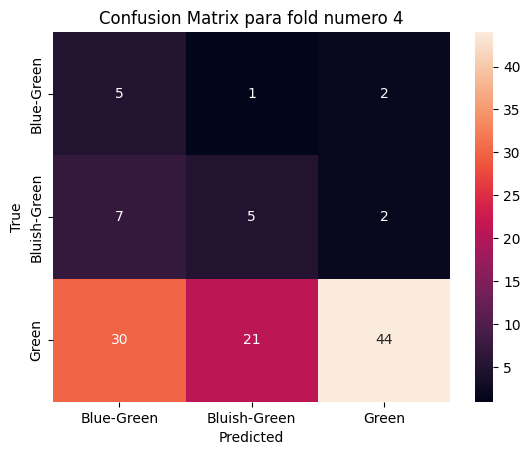

Classification Report para fold numero 4:
               precision    recall  f1-score   support

  Blue-Green       0.12      0.62      0.20         8
Bluish-Green       0.19      0.36      0.24        14
       Green       0.92      0.46      0.62        95

    accuracy                           0.46       117
   macro avg       0.41      0.48      0.35       117
weighted avg       0.77      0.46      0.54       117



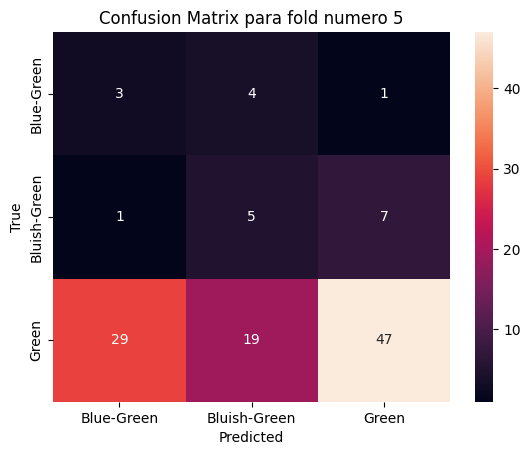

Classification Report para fold numero 5:
               precision    recall  f1-score   support

  Blue-Green       0.09      0.38      0.15         8
Bluish-Green       0.18      0.38      0.24        13
       Green       0.85      0.49      0.63        95

    accuracy                           0.47       116
   macro avg       0.37      0.42      0.34       116
weighted avg       0.73      0.47      0.55       116



In [63]:
fold = 1
for i, (train_index, val_index) in enumerate(kf.split(X_train_escalado, y_train)):
    
    #evitar el error out of index
    index_labels = y_train.index
    trainsc_df = pd.DataFrame(X_train_escalado, index=index_labels)


    X_train_fold, X_val_fold = trainsc_df.iloc[train_index], trainsc_df.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Train the model on the training fold
    svm.fit(X_train_fold, y_train_fold)

    # Predict on the validation fold
    y_pred_fold = svm.predict(X_val_fold)

    # Compute confusion matrix and classification report
    cm = confusion_matrix(y_val_fold, y_pred_fold)
    # Matriz de confusion x cada fold
    a = ["Blue-Green", "Bluish-Green", "Green"]
    sns.heatmap(cm, xticklabels=a, yticklabels=a, annot=True, fmt='g')
    plt.title(f"Confusion Matrix para fold numero {fold}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Print classification report
    print(f"Classification Report para fold numero {fold}:\n", classification_report(y_val_fold, y_pred_fold))

    fold += 1

- El problema persiste a pesar del split

# 3BIS. Realizar la predicción del atributo Color utilizando máquinas de vectores con kernelgaussiano analizando los parámetros costo y gama


## 3.1BIS SVM con kernel gaussiano sin cross validation

In [64]:
svm_gauss_nocross = SVC(kernel='rbf', C=0.1, random_state=42, gamma=0.001, class_weight='balanced')

In [65]:
svm_gauss_nocross.fit(X_train_escalado, y_train)

SVC(C=0.1, class_weight='balanced', gamma=0.001, random_state=42)

In [66]:
# Predicciones
y_pred_gauss = svm_linear_nocross.predict(X_test_escalado)

# Evaluación
accuracy = accuracy_score(y_test, y_pred_gauss)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 43.43%


In [67]:
dataframe['Color'].value_counts()

Color
Green           681
Bluish-Green     96
Blue-Green       58
Name: count, dtype: int64

              precision    recall  f1-score   support

  Blue-Green       0.09      0.44      0.15        16
Bluish-Green       0.15      0.34      0.21        29
       Green       0.87      0.45      0.59       206

    accuracy                           0.43       251
   macro avg       0.37      0.41      0.32       251
weighted avg       0.74      0.43      0.52       251



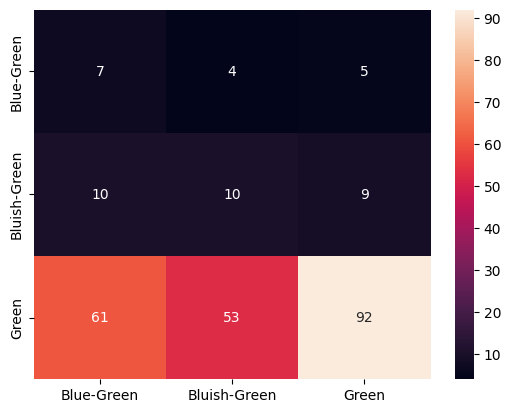

In [68]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


cm = (confusion_matrix(y_test, y_pred_gauss))
a = ["Blue-Green", "Bluish-Green", "Green"]

sns.heatmap(cm, xticklabels = a, yticklabels = a,annot=True, fmt='g')

print(classification_report(y_test, y_pred_gauss))

## 3.2BIS SVM con Kernel gaussiano y cross validation

In [69]:
svm_gaussiano = SVC(kernel='rbf', C=0.1, random_state=42, gamma=0.001, class_weight='balanced')

In [70]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

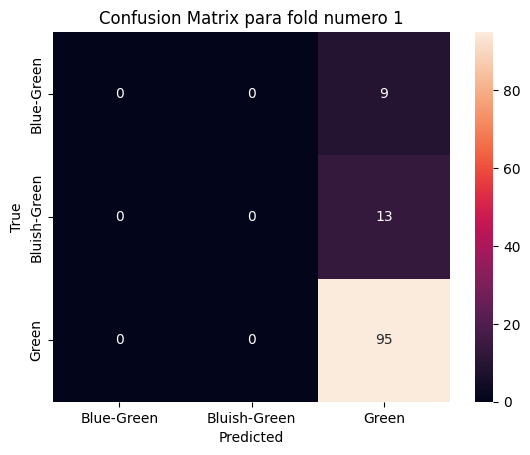

Classification Report para fold numero 1:
               precision    recall  f1-score   support

  Blue-Green       0.00      0.00      0.00         9
Bluish-Green       0.00      0.00      0.00        13
       Green       0.81      1.00      0.90        95

    accuracy                           0.81       117
   macro avg       0.27      0.33      0.30       117
weighted avg       0.66      0.81      0.73       117



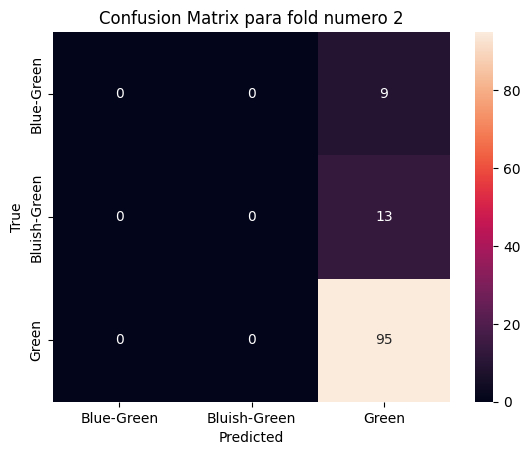

Classification Report para fold numero 2:
               precision    recall  f1-score   support

  Blue-Green       0.00      0.00      0.00         9
Bluish-Green       0.00      0.00      0.00        13
       Green       0.81      1.00      0.90        95

    accuracy                           0.81       117
   macro avg       0.27      0.33      0.30       117
weighted avg       0.66      0.81      0.73       117



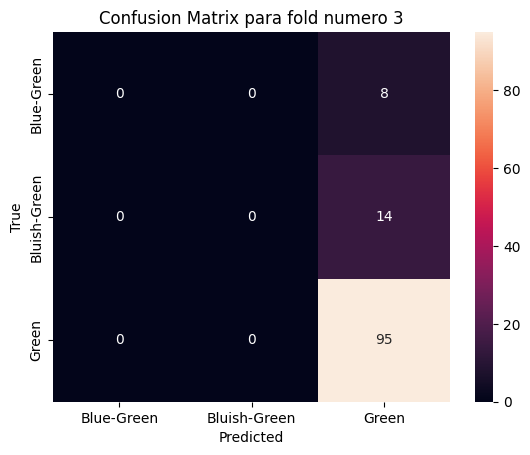

Classification Report para fold numero 3:
               precision    recall  f1-score   support

  Blue-Green       0.00      0.00      0.00         8
Bluish-Green       0.00      0.00      0.00        14
       Green       0.81      1.00      0.90        95

    accuracy                           0.81       117
   macro avg       0.27      0.33      0.30       117
weighted avg       0.66      0.81      0.73       117



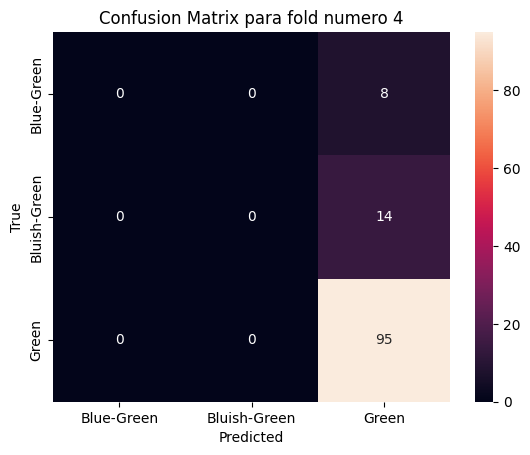

Classification Report para fold numero 4:
               precision    recall  f1-score   support

  Blue-Green       0.00      0.00      0.00         8
Bluish-Green       0.00      0.00      0.00        14
       Green       0.81      1.00      0.90        95

    accuracy                           0.81       117
   macro avg       0.27      0.33      0.30       117
weighted avg       0.66      0.81      0.73       117



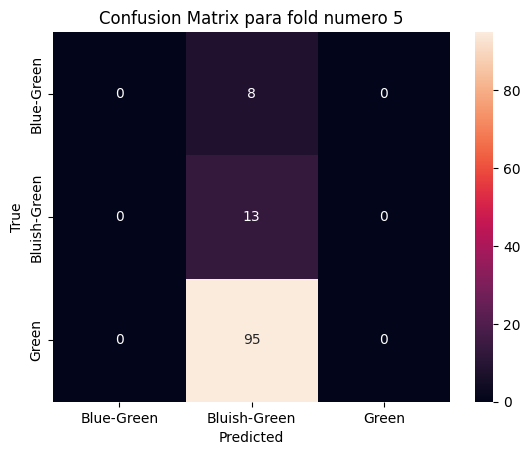

Classification Report para fold numero 5:
               precision    recall  f1-score   support

  Blue-Green       0.00      0.00      0.00         8
Bluish-Green       0.11      1.00      0.20        13
       Green       0.00      0.00      0.00        95

    accuracy                           0.11       116
   macro avg       0.04      0.33      0.07       116
weighted avg       0.01      0.11      0.02       116



In [71]:
fold = 1
for i, (train_index, val_index) in enumerate(kf.split(X_train_escalado, y_train)):
    
    #evitar el error out of index
    index_labels = y_train.index
    trainsc_df = pd.DataFrame(X_train_escalado, index=index_labels)


    X_train_fold, X_val_fold = trainsc_df.iloc[train_index], trainsc_df.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Train the model on the training fold
    svm_gaussiano.fit(X_train_fold, y_train_fold)

    # Predict on the validation fold
    y_pred_fold = svm_gaussiano.predict(X_val_fold)

    # Compute confusion matrix and classification report
    cm = confusion_matrix(y_val_fold, y_pred_fold)
    # Matriz de confusion x cada fold
    a = ["Blue-Green", "Bluish-Green", "Green"]
    sns.heatmap(cm, xticklabels=a, yticklabels=a, annot=True, fmt='g')
    plt.title(f"Confusion Matrix para fold numero {fold}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Print classification report
    print(f"Classification Report para fold numero {fold}:\n", classification_report(y_val_fold, y_pred_fold))



    fold += 1

# 4BIS. Realizar la predicción del atributo Color utilizando Random Forest analizando los parámetros cantidad de estimadores y la máxima profundidad de los árboles

## 4.1BIS random forest sin cross validation

In [72]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

In [73]:
forest_nocross = RandomForestClassifier(random_state=42, class_weight='balanced')

In [74]:
forest_nocross.fit(X_train_escalado, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [75]:
# Predicciones
y_pred_forest = forest_nocross.predict(X_test_escalado)

# Evaluación
accuracy = accuracy_score(y_test, y_pred_forest)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 82.07%


              precision    recall  f1-score   support

  Blue-Green       0.09      0.44      0.15        16
Bluish-Green       0.15      0.34      0.21        29
       Green       0.87      0.45      0.59       206

    accuracy                           0.43       251
   macro avg       0.37      0.41      0.32       251
weighted avg       0.74      0.43      0.52       251



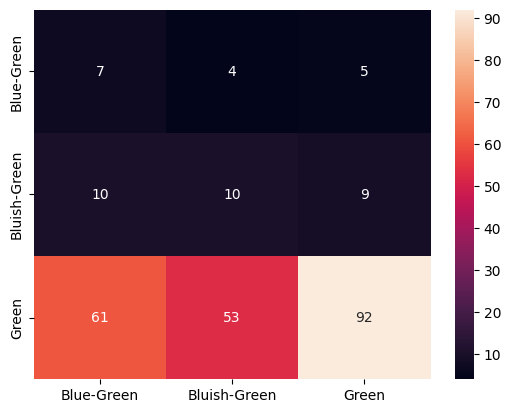

In [76]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


cm = (confusion_matrix(y_test, y_pred_linear))
a = ["Blue-Green", "Bluish-Green", "Green"]

sns.heatmap(cm, xticklabels = a, yticklabels = a,annot=True, fmt='g')

print(classification_report(y_test, y_pred_linear))

## 4.2BIS Random forest con cross validation e hiperparametros ajustados mediante grid search

In [77]:
rf_classifier = RandomForestClassifier(random_state=42)

# Definir los hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 250, 350],
    'max_depth': [30, 50],
    'class_weight':['balanced'],

}


grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring = ['accuracy', 'precision_macro', 'recall_macro'], refit='accuracy')


grid_search.fit(X_train_escalado, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
opt_rfd = grid_search.best_estimator_
print('Mejores hiperparámetros:', best_params)

Mejores hiperparámetros: {'class_weight': 'balanced', 'max_depth': 30, 'n_estimators': 350}


Mejores hiperparámetros: {'class_weight': 'balanced', 'max_depth': 30, 'max_features': 'sqrt', 'max_leaf_nodes': 300, 'max_samples': 50, 'min_samples_leaf': 10, 'n_estimators': 50, 'random_state': 42}

In [78]:
rand_forest = RandomForestClassifier(class_weight='balanced', max_depth=30, n_estimators=350)

In [79]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

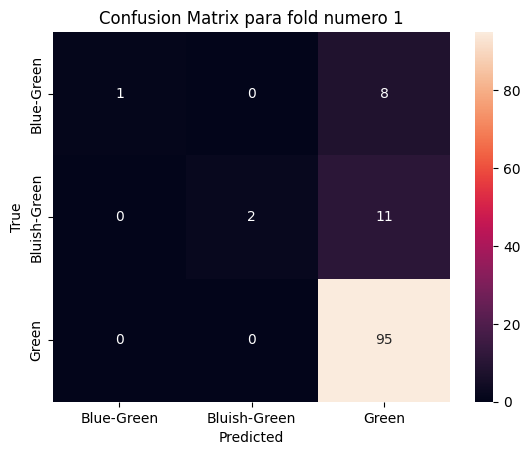

Classification Report para fold numero 1:
               precision    recall  f1-score   support

  Blue-Green       1.00      0.11      0.20         9
Bluish-Green       1.00      0.15      0.27        13
       Green       0.83      1.00      0.91        95

    accuracy                           0.84       117
   macro avg       0.94      0.42      0.46       117
weighted avg       0.86      0.84      0.78       117



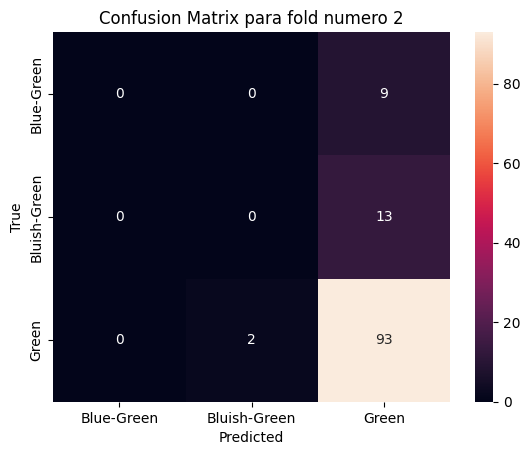

Classification Report para fold numero 2:
               precision    recall  f1-score   support

  Blue-Green       0.00      0.00      0.00         9
Bluish-Green       0.00      0.00      0.00        13
       Green       0.81      0.98      0.89        95

    accuracy                           0.79       117
   macro avg       0.27      0.33      0.30       117
weighted avg       0.66      0.79      0.72       117



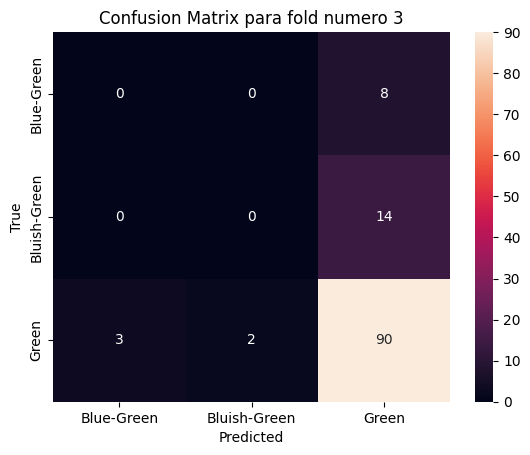

Classification Report para fold numero 3:
               precision    recall  f1-score   support

  Blue-Green       0.00      0.00      0.00         8
Bluish-Green       0.00      0.00      0.00        14
       Green       0.80      0.95      0.87        95

    accuracy                           0.77       117
   macro avg       0.27      0.32      0.29       117
weighted avg       0.65      0.77      0.71       117



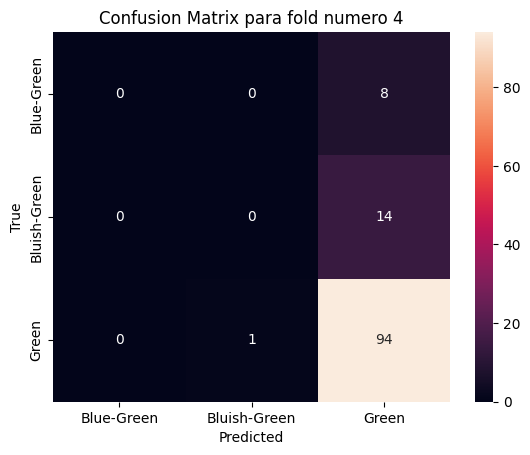

Classification Report para fold numero 4:
               precision    recall  f1-score   support

  Blue-Green       0.00      0.00      0.00         8
Bluish-Green       0.00      0.00      0.00        14
       Green       0.81      0.99      0.89        95

    accuracy                           0.80       117
   macro avg       0.27      0.33      0.30       117
weighted avg       0.66      0.80      0.72       117



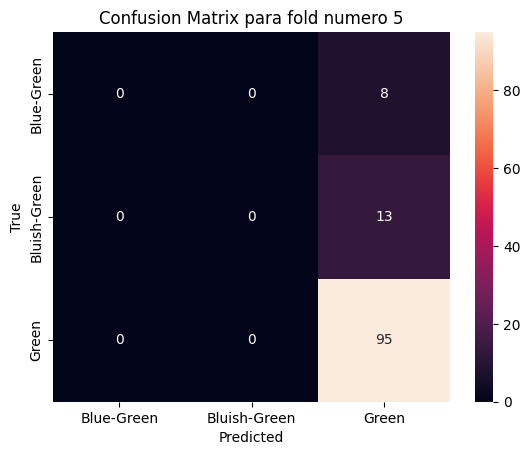

Classification Report para fold numero 5:
               precision    recall  f1-score   support

  Blue-Green       0.00      0.00      0.00         8
Bluish-Green       0.00      0.00      0.00        13
       Green       0.82      1.00      0.90        95

    accuracy                           0.82       116
   macro avg       0.27      0.33      0.30       116
weighted avg       0.67      0.82      0.74       116



In [80]:
fold = 1
for i, (train_index, val_index) in enumerate(kf.split(X_train_escalado, y_train)):
    
    #evitar el error out of index
    index_labels = y_train.index
    trainsc_df = pd.DataFrame(X_train_escalado, index=index_labels)


    X_train_fold, X_val_fold = trainsc_df.iloc[train_index], trainsc_df.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Train the model on the training fold
    rand_forest.fit(X_train_fold, y_train_fold)

    # Predict on the validation fold
    y_pred_fold = rand_forest.predict(X_val_fold)

    # Compute confusion matrix and classification report
    cm = confusion_matrix(y_val_fold, y_pred_fold)
    # Matriz de confusion x cada fold
    a = ["Blue-Green", "Bluish-Green", "Green"]
    sns.heatmap(cm, xticklabels=a, yticklabels=a, annot=True, fmt='g')
    plt.title(f"Confusion Matrix para fold numero {fold}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Print classification report
    print(f"Classification Report para fold numero {fold}:\n", classification_report(y_val_fold, y_pred_fold))



    fold += 1

Graficar feature importance

In [81]:
cols_pred = list(X_train.columns.values)

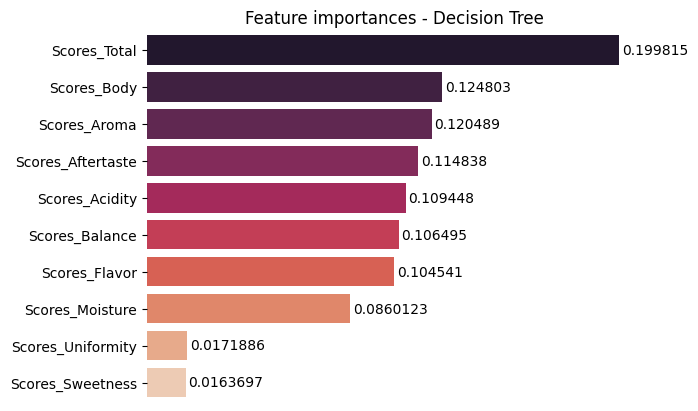

In [82]:
#columnas e importancia
features_df = pd.DataFrame({'features': cols_pred, 'importances': opt_rfd.feature_importances_ })

# ordenar de mayor a menor
features_df_sorted = features_df.sort_values(by='importances', ascending=False)

# Barplot
g = sns.barplot(data=features_df_sorted, x='importances', y ='features', palette="rocket")
sns.despine(bottom = True, left = True)
g.set_title('Feature importances - Decision Tree')
g.set(xlabel=None)
g.set(ylabel=None)
g.set(xticks=[])
for value in g.containers:
    g.bar_label(value, padding=2)

#

# Conclusiones

- El desbalance en las clases, donde la clase "Green" es significativamente más grande que las otras dos clases, afecta negativamente el rendimiento de los modelos de clasificación. Esto se evidencia en el hecho de que los modelos tienden a predecir predominantemente la clase mayoritaria.

- Para el modelo SVC con kernel lineal, el rendimiento bajo y la predicción de todos los datos como pertenecientes a la clase "Green" da indicio de que el modelo lineal no es capaz de capturar la complejidad de las relaciones entre las características

- La predicción de todos los datos como pertenecientes a la clase mayoritaria muestra que el modelo con kernel gaussiano también tiene dificultades para manejar la complejidad del problema.


- El modelo lineal puede ser más sensible a outliers que afectan la relación lineal. Random Forest, al ser basado en árboles y mas robusto, puede ser menos propenso a la influencia de outliers.

- El modelo SVC con kernel lineal asume una relación lineal entre las características y la variable objetivo. Por lo tanto, los coeficientes que asigna reflejan la contribución lineal de cada característica. Si las relaciones son complejas o no lineales, el modelo lineal puede no capturar completamente esas sutilezas.

- Random Forest es un modelo más robusto que puede manejar relaciones no lineales y complejas entre las características y la variable objetivo. Al utilizar múltiples árboles de decisión y combinar sus resultados

- El desbalance es uno de los mayores desafíos a considerar en el desempeño de los modelos.

- El problema de desbalance pudo mitigarse con hiperparametros que presentan los metodos de sklearn

